In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras as kr
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# Data Engineering and preprocessing

Make a functions for creating the dataframe with images and information there

In [6]:
def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    return df

Find a path to our images

In [7]:
train = Path('train')
test = Path('test')
val = Path('validation')

train_filepaths = list(train.glob(r'**/*.jpg'))
test_filepaths = list(test.glob(r'**/*.jpg'))
val_filepaths = list(test.glob(r'**/*.jpg'))

Make a dataframes from the images and information we have

In [8]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

See the result

In [5]:
train_df.head(5)

,Filepath,Label
0,train/bell pepper/Image_50.jpg,bell pepper
1,train/pear/Image_81.jpg,pear
2,train/peas/Image_35.jpg,peas
3,train/paprika/Image_42.jpg,paprika
4,train/eggplant/Image_96.jpg,eggplant


In [6]:
test_df.head(5)

,Filepath,Label
0,test/turnip/Image_6.jpg,turnip
1,test/capsicum/Image_10.jpg,capsicum
2,test/banana/Image_6.jpg,banana
3,test/apple/Image_2.jpg,apple
4,test/spinach/Image_8.jpg,spinach


In [7]:
val_df.head(5)

,Filepath,Label
0,test/orange/Image_3.jpg,orange
1,test/carrot/Image_5.jpg,carrot
2,test/eggplant/Image_6.jpg,eggplant
3,test/lemon/Image_8.jpg,lemon
4,test/jalepeno/Image_7.jpg,jalepeno


In [8]:
train_df.describe(include="all")

,Filepath,Label
count,2780,2780
unique,2780,36
top,train/bell pepper/Image_50.jpg,soy beans
freq,1,92


Let's see all images by unigue labels(show them)

In [9]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

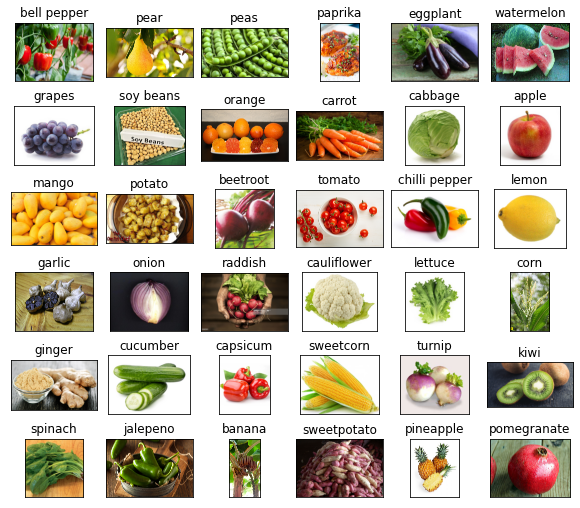

In [10]:
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# Load the Images with a generator and Data Augmentation

First of all, make new function for generator with a different preprocessing functions

In [4]:
def set_generator(function):
    generator = ImageDataGenerator(preprocessing_function = function)
    train_images = generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    val_images = generator.flow_from_dataframe(
        dataframe=val_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    test_images = generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    return train_images, val_images, test_images

# Train the model

Secondly, train the model

In [14]:
def train_model_params(model_train, activation,tr, val):
    pretrained_model = model_train
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = kr.layers.Dense(128, activation= activation)(pretrained_model.output)
    x = kr.layers.Dense(128, activation= activation)(x)

    outputs = kr.layers.Dense(36, activation='softmax')(x)

    model = kr.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(tr, validation_data=val, batch_size = 32, epochs=5)

    return history, model

And make the predictions

In [15]:
def make_predictions(model, tr, ts):
    # Predict the label of the test_images
    pred = model.predict(ts)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (tr.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = [labels[k] for k in ts.classes]

    # Count Accuracy
    acc = accuracy_score(y_test, pred)
    print(f'Accuracy on the test set: {100*acc:.2f}%')

    # Show images
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
        ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
    plt.tight_layout()
    plt.show()

For the first example I decided to use MobileNetV2 arhitecture for test

In [14]:
train_images, val_images, test_images = set_generator(kr.applications.mobilenet_v2.preprocess_input)
param = kr.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    pooling='avg'
)
hist, mod = train_model_params(param, 'relu', train_images, val_images)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


2022-02-19 20:33:47.421717: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
87/87 [==============================] - 317s 4s/step - loss: 1.8268 - accuracy: 0.5140 - val_loss: 0.4954 - val_accuracy: 0.8503
Epoch 2/5
87/87 [==============================] - 309s 4s/step - loss: 0.5821 - accuracy: 0.8104 - val_loss: 0.3045 - val_accuracy: 0.9042
Epoch 3/5
87/87 [==============================] - 297s 3s/step - loss: 0.3396 - accuracy: 0.8935 - val_loss: 0.2256 - val_accuracy: 0.9371
Epoch 4/5
87/87 [==============================] - 384s 4s/step - loss: 0.2194 - accuracy: 0.9277 - val_loss: 0.2106 - val_accuracy: 0.9311
Epoch 5/5
87/87 [==============================] - 540s 6s/step - loss: 0.1570 - accuracy: 0.9518 - val_loss: 0.2178 - val_accuracy: 0.9311


Accuracy on the test set: 93.11%


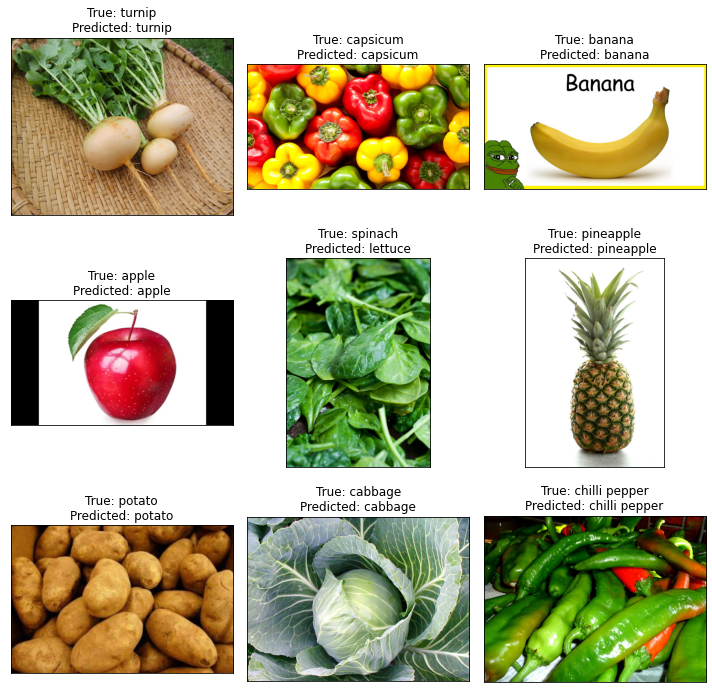

In [15]:
make_predictions(mod, train_images, test_images)

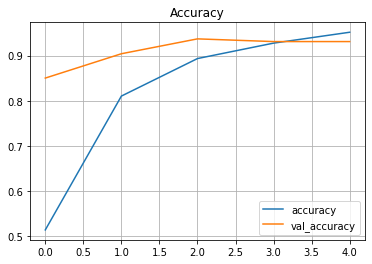

In [16]:
pd.DataFrame(hist.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.grid()
plt.show()

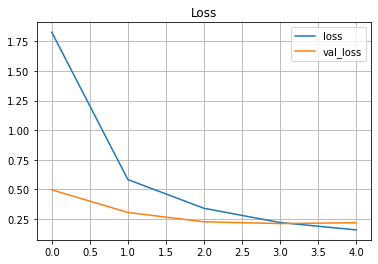

In [17]:
pd.DataFrame(hist.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.grid()
plt.show()

# ResNet50V2

In [12]:
train_images, val_images, test_images = set_generator(kr.applications.resnet_v2.preprocess_input)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [16]:
param = kr.applications.ResNet50V2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    pooling='avg'
)
hist, mod = train_model_params(param, 'relu', train_images, val_images)

Epoch 1/5
87/87 [==============================] - 360s 4s/step - loss: 1.7803 - accuracy: 0.5270 - val_loss: 0.5155 - val_accuracy: 0.8563
Epoch 2/5
87/87 [==============================] - 348s 4s/step - loss: 0.6361 - accuracy: 0.7968 - val_loss: 0.3860 - val_accuracy: 0.8683
Epoch 3/5
87/87 [==============================] - 350s 4s/step - loss: 0.3636 - accuracy: 0.8842 - val_loss: 0.2402 - val_accuracy: 0.9371
Epoch 4/5
87/87 [==============================] - 350s 4s/step - loss: 0.2090 - accuracy: 0.9399 - val_loss: 0.2072 - val_accuracy: 0.9401
Epoch 5/5
87/87 [==============================] - 354s 4s/step - loss: 0.1479 - accuracy: 0.9525 - val_loss: 0.1814 - val_accuracy: 0.9581


Accuracy on the test set: 95.21%


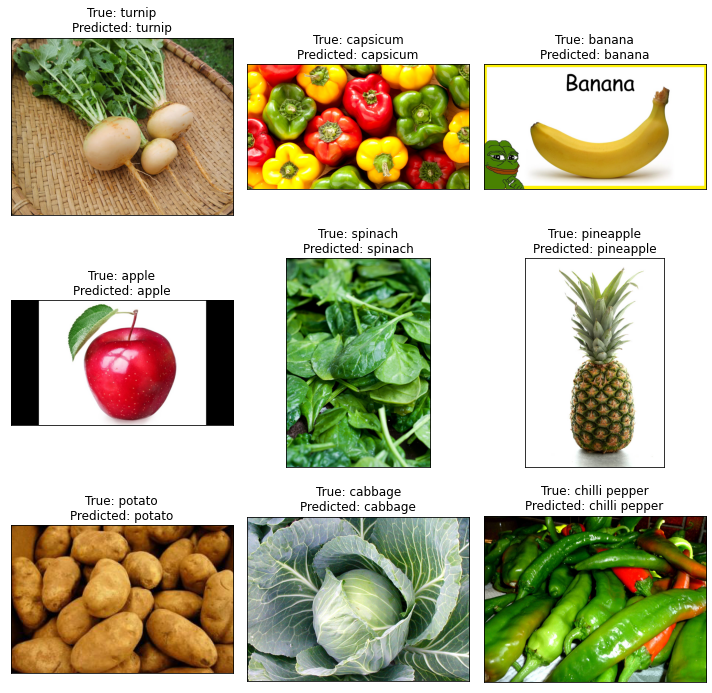

In [20]:
make_predictions(mod, train_images, test_images)

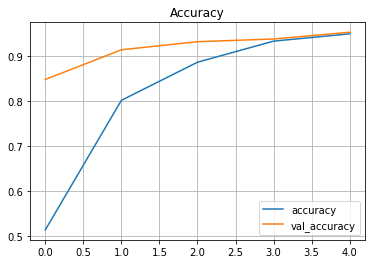

In [21]:
pd.DataFrame(hist.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.grid()
plt.show()

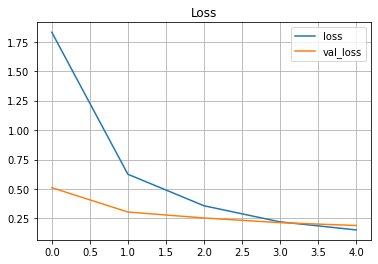

In [22]:
pd.DataFrame(hist.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.grid()
plt.show()

# Xception

In [24]:
train_images, val_images, test_images = set_generator(kr.applications.xception.preprocess_input)
param = kr.applications.Xception(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',
    pooling='avg'
)
hist, mod = train_model_params(param, 'relu', train_images, val_images)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
83697664/83683744 [==============================] - 9s 0us/step
Epoch 1/5
87/87 [==============================] - 540s 6s/step - loss: 1.7419 - accuracy: 0.5367 - val_loss: 0.5784 - val_accuracy: 0.8204
Epoch 2/5
87/87 [==============================] - 476s 5s/step - loss: 0.7064 - accuracy: 0.7741 - val_loss: 0.4061 - val_accuracy: 0.8713
Epoch 3/5
87/87 [==============================] - 474s 5s/step - loss: 0.5129 - accuracy: 0.8299 - val_loss: 0.2658 - val_accuracy: 0.9102
Epoch 4/5
87/87 [==============================] - 480s 6s/step - loss: 0.3591 - accuracy: 0.8730 - val_loss: 0.2250 - val_accuracy: 0.9311
Epoch 5/5
87/87 [==============================] - 486s 6s/step - loss: 0.2554 - accuracy: 0.9155 - val_loss: 0.2218 - val_accuracy: 0.9431


Accuracy on the test set: 94.31%


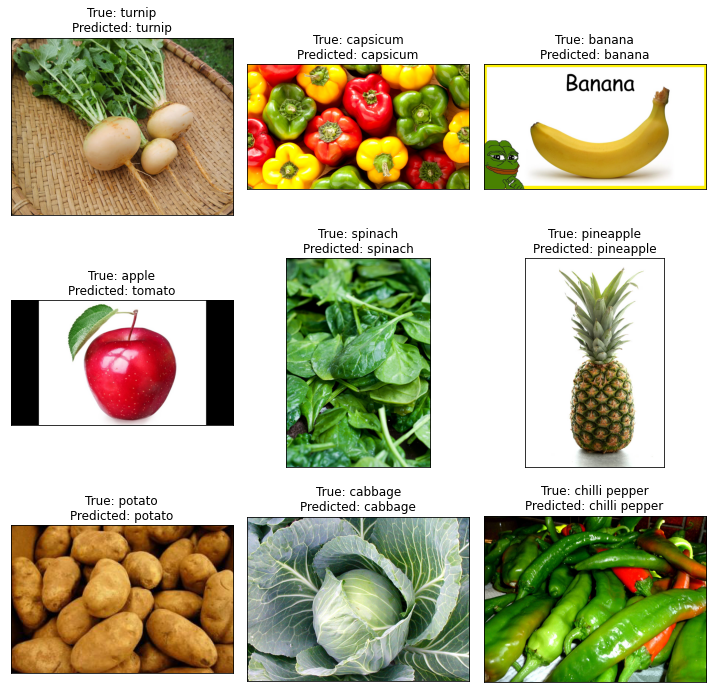

In [25]:
make_predictions(mod, train_images, test_images)

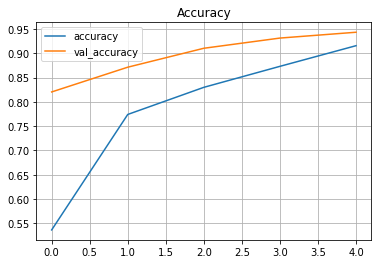

In [26]:
pd.DataFrame(hist.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.grid()
plt.show()

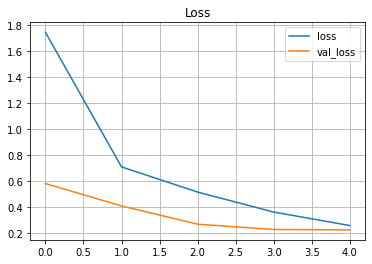

In [27]:
pd.DataFrame(hist.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.grid()
plt.show()

# TSNE Visualization

In [19]:
tsne = TSNE(n_components=2).fit_transform(test_images)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
reduced_transformed = reduced - np.min(reduced, axis=0)
reduced_transformed /= np.max(reduced_transformed, axis=0)
image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

In [ ]:
image_width = 64 # width and height of each visualized images
feature_extraction = 'inception' # feature extraction method

In [ ]:
merged_width = int(np.ceil(np.sqrt(no_of_images))*image_width)
merged_image = np.zeros((merged_width, merged_width, 3), dtype='uint8')

for counter, index in enumerate(image_xindex_sorted):
    # set location
    a = np.ceil(reduced_transformed[counter, 0] * (merged_width-image_width-1)+1)
    b = np.ceil(reduced_transformed[counter, 1] * (merged_width-image_width-1)+1)
    a = int(a - np.mod(a-1,image_width) + 1)
    b = int(b - np.mod(b-1,image_width) + 1)
    if merged_image[a,b,0] != 0:
        continue
    image_address = image_names[counter]
    img = np.asarray(Image.open(image_address).resize((image_width, image_width)))
    merged_image[a:a+image_width, b:b+image_width,:] = img[:,:,:3]

plt.imshow(merged_image)
plt.show()